# Part 2 - LSTM

## Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import json
import gensim
import re
import torch.optim as optim
from torchtext.vocab import GloVe, FastText
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load processed data

In [2]:
with open('../data_processed/LR_train_tagged.json') as f: 
    LR_train = json.load(f)
    
with open('../data_processed/LR_test_tagged.json') as f:
    LR_test = json.load(f)
    
with open('../data_processed/LR_val_tagged.json') as f:
    LR_val = json.load(f)

with open('../data_processed/NER_train_tagged.json') as f:
    NER_train = json.load(f)

with open('../data_processed/NER_test_tagged.json') as f:
    NER_test = json.load(f)

with open('../data_processed/NER_val_tagged.json') as f:
    NER_val = json.load(f)


## Load vector embedding models

### Word2Vec


In [3]:
w2vmodel = KeyedVectors.load_word2vec_format('../.vector_cache/GoogleNews-vectors-negative300.bin', binary=True)

### GloVe


In [4]:
# glovemodel = GloVe(name='6B', dim=300)
glove_file = '../.vector_cache/glove.6B.300d.txt'
glovemodel = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glovemodel[word] = vector


### Fasttext

In [5]:
# fasttextmodel = FastText()
fasttext_file = '../.vector_cache/wiki.en.vec'
fastmodel = {}
with open(fasttext_file, 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.array([x for x in values[1:] if x], dtype='float32')
        fastmodel[word] = vector

## Creating and Training the Models

### Create list of unique labels - NER

In [6]:
unique_labels = []
for entry in NER_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_NER = {}
unique_labels = list(set(unique_labels))
unique_labels = sorted(unique_labels)

for label_index in range(len(unique_labels)):
    label_dict_NER[unique_labels[label_index]] = label_index

# label_dict_NER['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1

output_dict = {}
for key, value in label_dict_NER.items():
    new_key = key.replace('B_', '').replace('I_', '')
    if new_key not in output_dict:
        output_dict[new_key] = len(output_dict)

label_dict_NER = output_dict
label_dict_NER

{'CASE_NUMBER': 0,
 'COURT': 1,
 'DATE': 2,
 'GPE': 3,
 'JUDGE': 4,
 'ORG': 5,
 'OTHER_PERSON': 6,
 'PETITIONER': 7,
 'PRECEDENT': 8,
 'PROVISION': 9,
 'RESPONDENT': 10,
 'STATUTE': 11,
 'WITNESS': 12,
 'O': 13}

### Create list of unique labels - LR

In [7]:
unique_labels = []
for entry in LR_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_LR = {}
unique_labels = list(set(unique_labels))
unique_labels = sorted(unique_labels)

for label_index in range(len(unique_labels)):
    label_dict_LR[unique_labels[label_index]] = label_index

# label_dict_LR['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1
label_dict_LR

{'B': 0, 'I': 1, 'O': 2}

### Verifying LR_train

In [8]:
# id = 0
# for entry in LR_train:
#     if (len(entry['text'].split()) != len(entry['labels'])):
#         print(entry['id'])
#         print(len(entry['text'].split()))
#         print(len(entry['labels']))

### Define NER dataset class

In [9]:
class NER_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"
        # self.padding_word = "p0p"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)
            
        self.data = dataset
        self.input = []
        self.labels = []
        
        for i in range(len(self.data)):
            lst = self.data[i]["labels"]
            for j in range(len(lst)):
                if lst[j].startswith("B_"):
                    lst[j] = lst[j][2:]
                elif lst[j].startswith("I_"):
                    lst[j] = lst[j][2:]
            self.data[i]["labels"] = lst

        if padding:
            for entry in self.data:
                padded_entry = entry["text"].split() + [self.padding_word] * (75 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (75 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in self.data:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_NER

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []
        
        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Define LR Dataset class

In [10]:
class LR_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)

        self.data = dataset
        self.input = []
        self.labels = []
        if padding:
            for entry in dataset:
                padded_entry = entry["text"].split() + [self.padding_word] * (78 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (78 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in dataset:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_LR

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []

        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Training Loop

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    train_accuracy_scores = []
    val_accuracy_scores = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        all_val_labels = []
        all_val_preds = []

        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs, hn = model(inputs)
            outputs = outputs.reshape(-1, outputs.shape[-1])
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
        train_accuracy_scores.append(train_accuracy)
        train_f1_scores.append(train_f1)

        model.eval()
        with torch.no_grad():

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs, hn = model(inputs)
                outputs = outputs.reshape(-1, outputs.shape[-1])
                labels = labels.reshape(-1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

            val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
            val_accuracy_scores.append(val_accuracy)
            val_f1_scores.append(val_f1)

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch {epoch + 1}\n"
              f"Train loss: {train_losses[-1]}, Val loss: {val_losses[-1]}\n"
              f"Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}\n"
              f"Train F1: {train_f1}, Val F1: {val_f1}")
        print("=====================================================================================================")

    return model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores
        

### Modified NN models

In [12]:
class SequentialModel(nn.Module):
    def __init__(self, label_dict, base_model):
        super().__init__()
        self.sequential_model = base_model
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, len(label_dict))
        self.relu = nn.ReLU()

    def forward(self, x):
        x, hn = self.sequential_model(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x, hn

## Word2Vec Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [13]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "word2vec", padding=True), batch_size=64, shuffle=True)

c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [14]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "word2vec", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [15]:
model = SequentialModel(label_dict_NER, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [16]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t1_lstm_word2vec.pt")

C:\Users\Jaskaran\AppData\Local\Temp\ipykernel_26836\4087966327.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(word_vecs), torch.tensor(labels)


Epoch 1
Train loss: 0.4484110491484711, Val loss: 0.2773958453360726
Train accuracy: 0.9018154327987472, Val accuracy: 0.9232442396313364
Train F1: 0.08463868149448799, Val F1: 0.14988912384123923
Epoch 2
Train loss: 0.20725819529946318, Val loss: 0.1560731135747012
Train accuracy: 0.941232247961553, Val accuracy: 0.9511029185867895
Train F1: 0.34742377001381763, Val F1: 0.44333223130882354
Epoch 3
Train loss: 0.13711719176511175, Val loss: 0.12987020830897725
Train accuracy: 0.9578767752038447, Val accuracy: 0.9601843317972351
Train F1: 0.5022967628458964, Val F1: 0.5235398251092552


In [17]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9600694444444444 Test F1: 0.516547539280886


### Plots

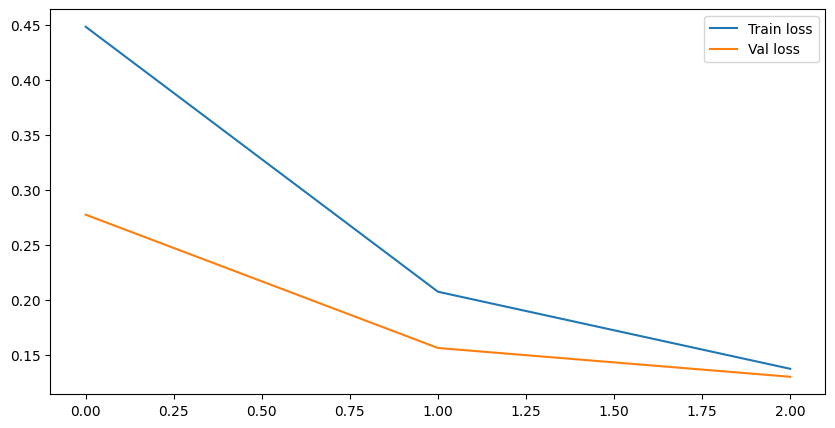

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

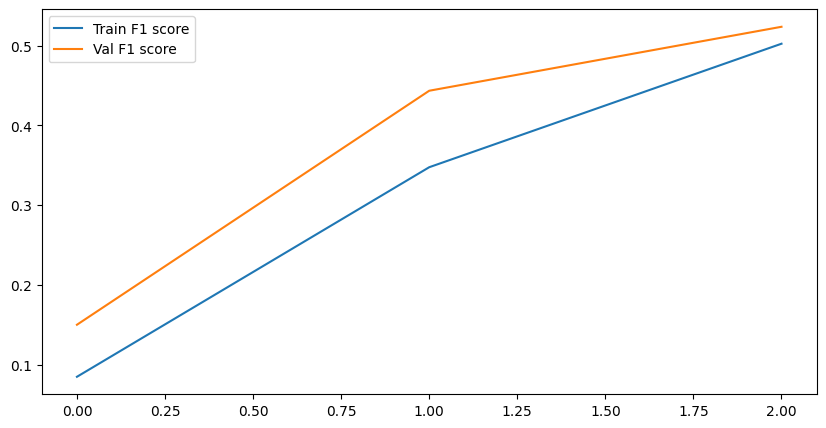

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

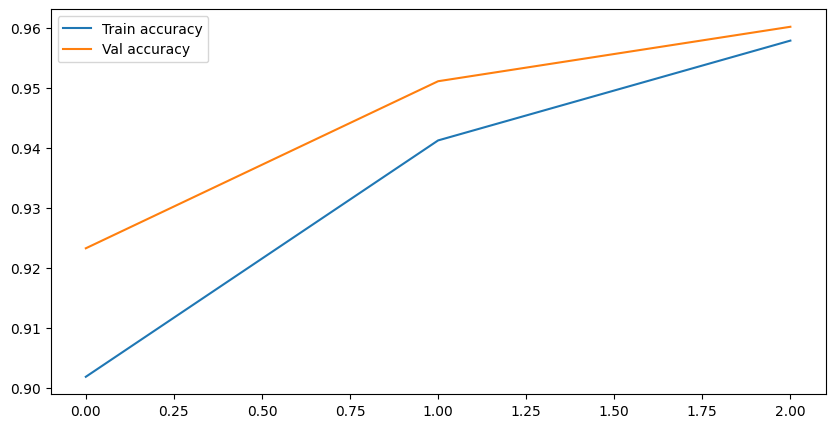

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [21]:
model = SequentialModel(label_dict_LR, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [22]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t2_lstm_word2vec.pt")

Epoch 1
Train loss: 0.22983262439568838, Val loss: 0.11553536305824916
Train accuracy: 0.959684722929756, Val accuracy: 0.9736089885096507
Train F1: 0.3469555612763449, Val F1: 0.328876014846575
Epoch 2
Train loss: 0.09939687500397364, Val loss: 0.0838321511944135
Train accuracy: 0.9736089885096507, Val accuracy: 0.9739061527140997
Train F1: 0.328876014846575, Val F1: 0.33967822898715
Epoch 3
Train loss: 0.07406479890147845, Val loss: 0.06700280209382375
Train accuracy: 0.9750523575026886, Val accuracy: 0.9754485764419539
Train F1: 0.40365317211717194, Val F1: 0.4437829582673131


In [23]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9754485764419539 Test F1: 0.4437829582673131


### Plots

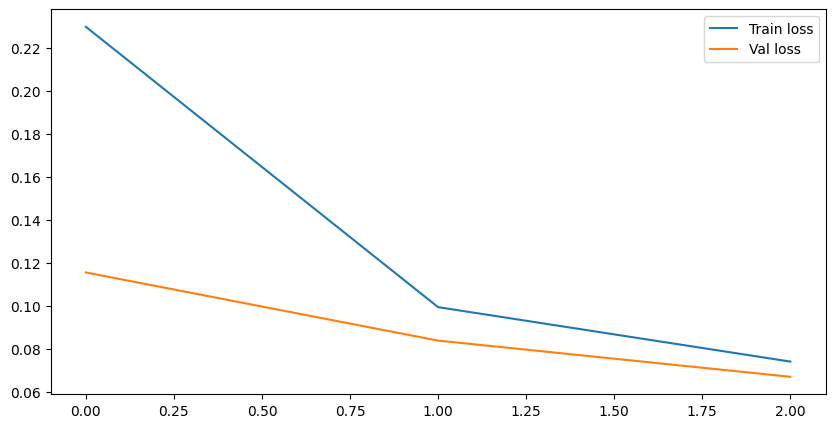

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

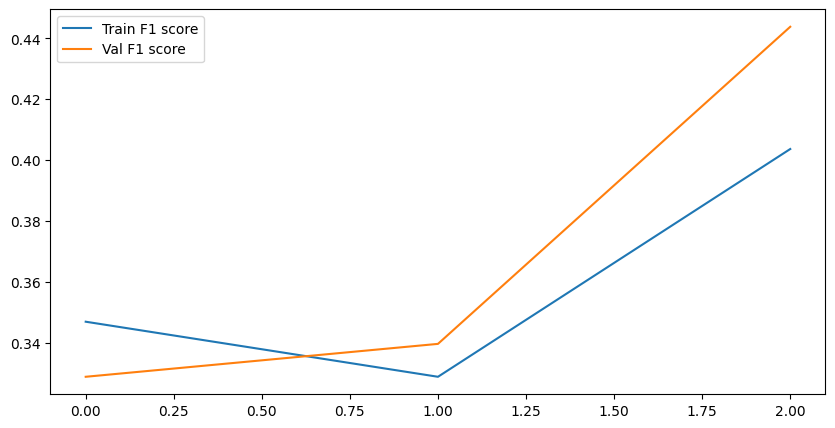

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

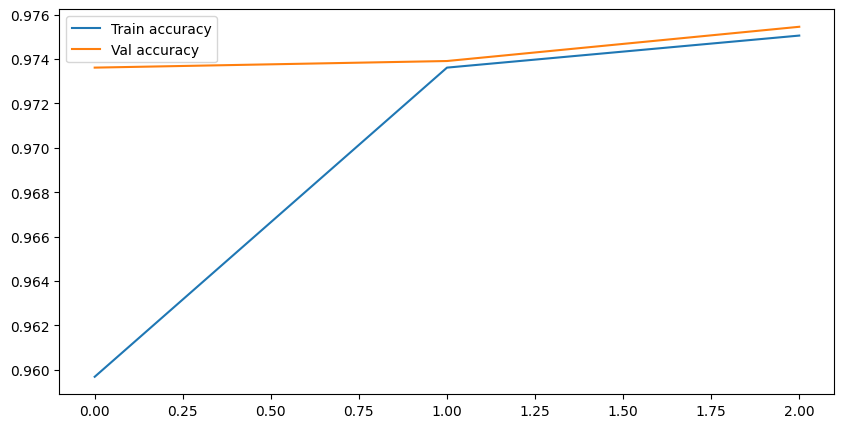

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## GloVe Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [27]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "glove", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "glove", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "glove", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [28]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "glove", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "glove", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "glove", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [29]:
model = SequentialModel(label_dict_NER, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [30]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t1_lstm_glove.pt")

Epoch 1
Train loss: 0.4387988260726339, Val loss: 0.2967162886086632
Train accuracy: 0.912554673578487, Val accuracy: 0.923010752688172
Train F1: 0.11308383149797942, Val F1: 0.1830221670818131
Epoch 2
Train loss: 0.2444664000235882, Val loss: 0.21910434084780075
Train accuracy: 0.9325859927641881, Val accuracy: 0.9374132104454685
Train F1: 0.2721593762646946, Val F1: 0.30938463753954254
Epoch 3
Train loss: 0.20508606562909393, Val loss: 0.2063109690652174
Train accuracy: 0.9399514012635671, Val accuracy: 0.9403625192012289
Train F1: 0.3465998431909562, Val F1: 0.36124613898560337


In [31]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9391145833333333 Test F1: 0.351549918776443


### Plots

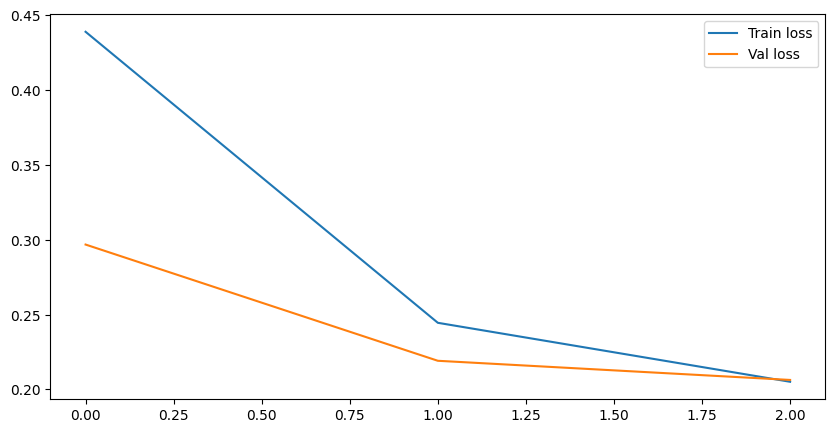

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

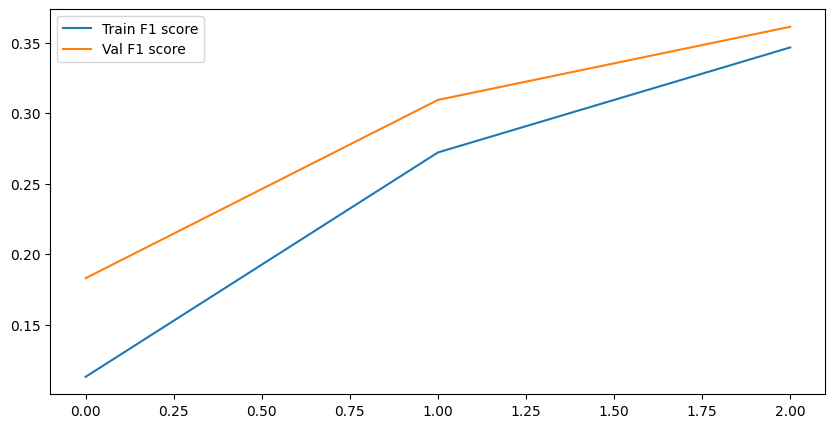

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

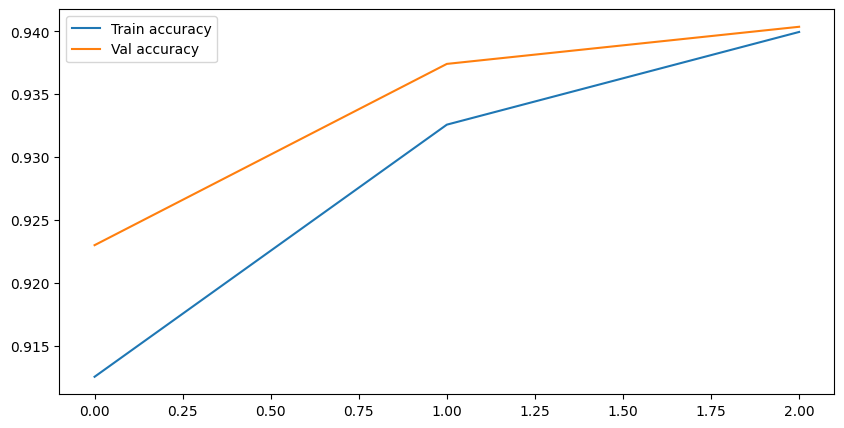

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training

In [35]:
model = SequentialModel(label_dict_LR, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [36]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t2_lstm_glove.pt")

Epoch 1
Train loss: 0.2408708800872167, Val loss: 0.09697005103031794
Train accuracy: 0.9735948378332484, Val accuracy: 0.9736089885096507
Train F1: 0.3288735928873593, Val F1: 0.3293955664127047
Epoch 2
Train loss: 0.08470865587393443, Val loss: 0.07545005232095718
Train accuracy: 0.9737363445972718, Val accuracy: 0.9736372898624555
Train F1: 0.37749997505166405, Val F1: 0.4575072597410168
Epoch 3
Train loss: 0.07019407004117965, Val loss: 0.059304766605297723
Train accuracy: 0.9768919454349918, Val accuracy: 0.9806277240052075
Train F1: 0.5901318683088989, Val F1: 0.6766263742406173


In [37]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9806277240052075 Test F1: 0.6766263742406173


### Plots

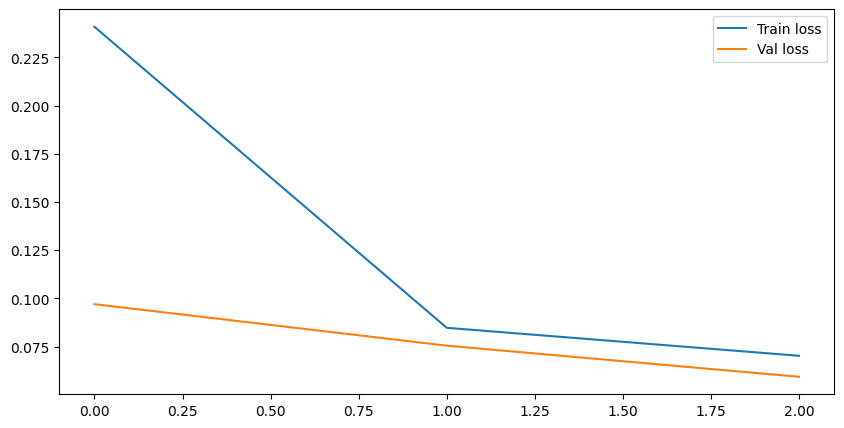

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

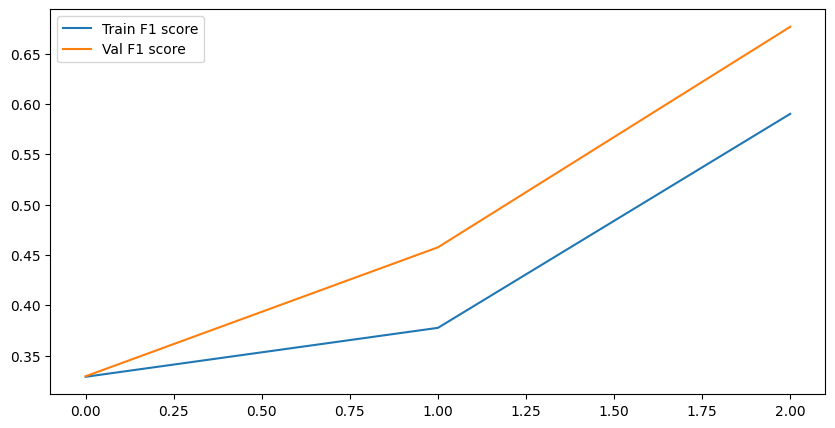

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

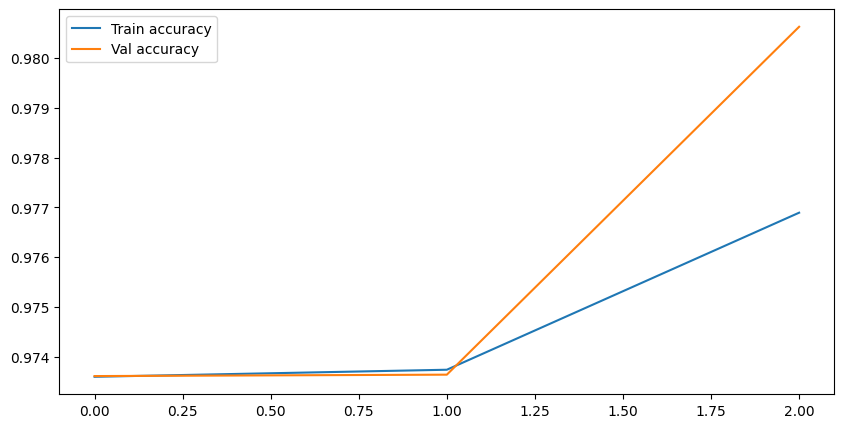

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## Fasttext Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [41]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [42]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [43]:
model = SequentialModel(label_dict_NER, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [44]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t1_lstm_fasttext.pt")

Epoch 1
Train loss: 0.5352473553922987, Val loss: 0.5109203633140115
Train accuracy: 0.8993984556401533, Val accuracy: 0.906199692780338
Train F1: 0.06884447502365204, Val F1: 0.0679137130589905
Epoch 2
Train loss: 0.4231593532046092, Val loss: 0.3614882493720335
Train accuracy: 0.9097726659106863, Val accuracy: 0.9108940092165899
Train F1: 0.07652663111905038, Val F1: 0.09437846920467326
Epoch 3
Train loss: 0.3358708916558433, Val loss: 0.333894200184766
Train accuracy: 0.9144381446082401, Val accuracy: 0.9125161290322581
Train F1: 0.10496011074934561, Val F1: 0.12666513684465155


In [45]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9136979166666667 Test F1: 0.1305948742926195


### Plots

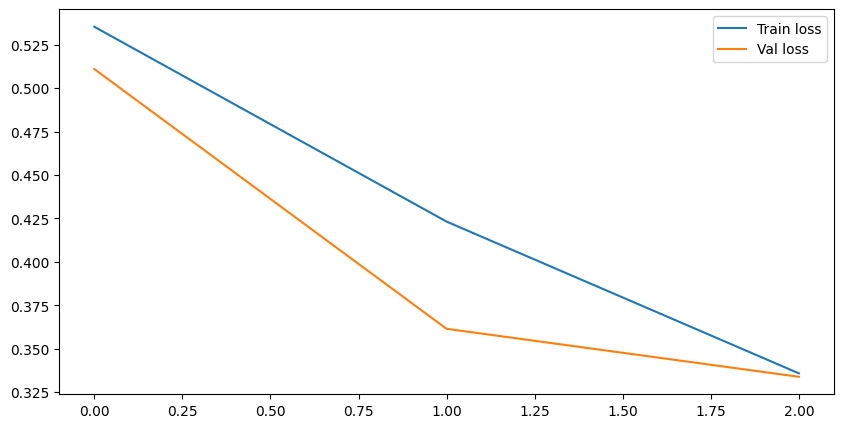

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

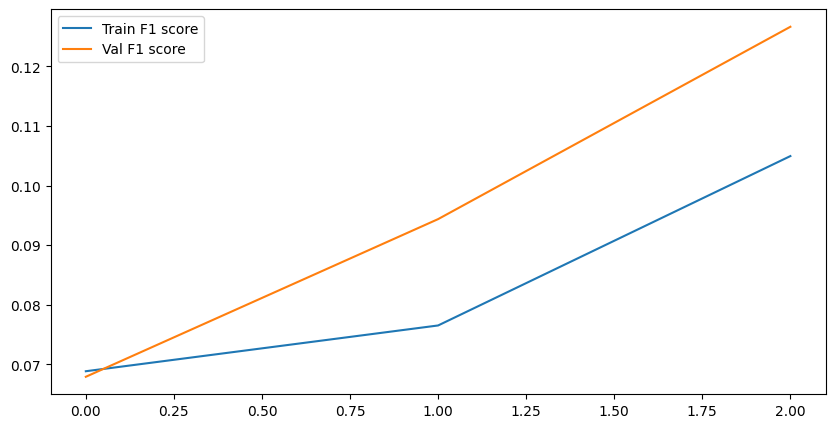

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

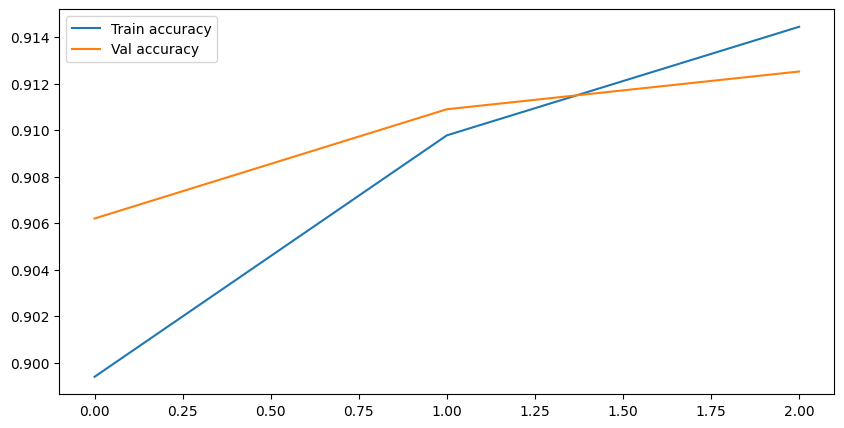

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [49]:
model = SequentialModel(label_dict_LR, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [50]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t2_lstm_fasttext.pt")

Epoch 1
Train loss: 0.2551064242919286, Val loss: 0.10544179181257883
Train accuracy: 0.9154780098488707, Val accuracy: 0.9736089885096507
Train F1: 0.32683437097249435, Val F1: 0.328876014846575
Epoch 2
Train loss: 0.090060227115949, Val loss: 0.08065721690654755
Train accuracy: 0.9736089885096507, Val accuracy: 0.9736089885096507
Train F1: 0.328876014846575, Val F1: 0.328876014846575
Epoch 3
Train loss: 0.07723842561244965, Val loss: 0.06791075989603997
Train accuracy: 0.9752221656195166, Val accuracy: 0.9767645893473708
Train F1: 0.423672424705624, Val F1: 0.4786169929159159


In [51]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9767645893473708 Test F1: 0.4786169929159159


### Plots

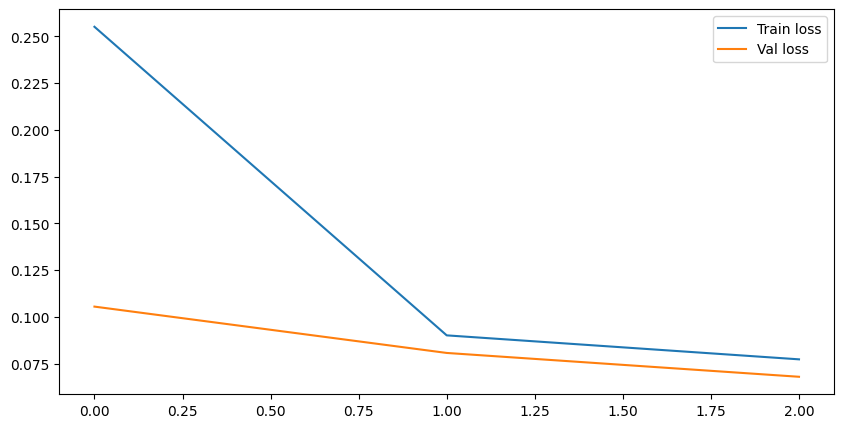

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

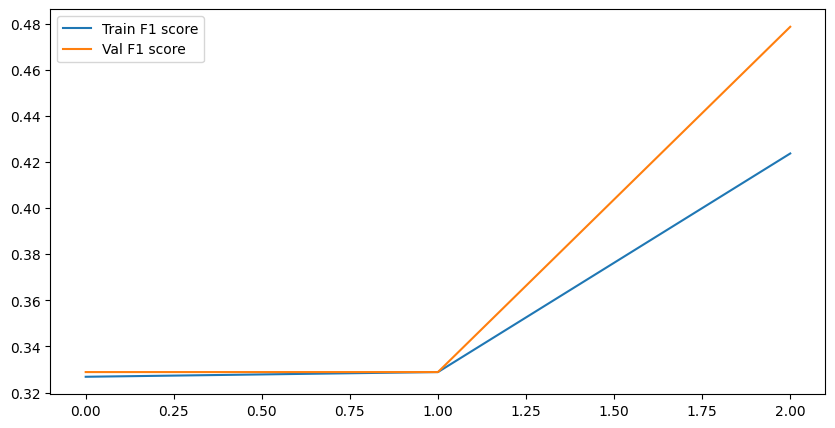

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

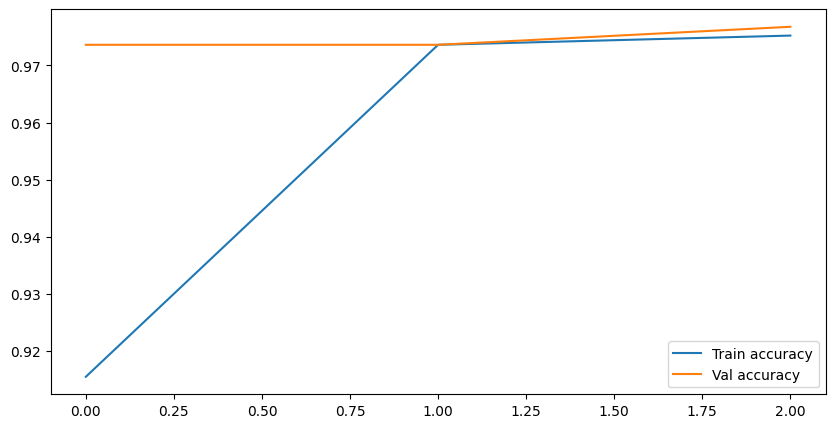

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()